In [10]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
import random
random.seed(2635)

DataCleaning

In [4]:
import yfinance as yf

tick = 'GC=F'
gold = yf.download(tick, start='2019-11-22', interval='5d')

print(gold.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open Volume
Ticker             GC=F         GC=F         GC=F         GC=F   GC=F
Date                                                                 
2019-11-22  1463.099976  1468.599976  1463.099976  1468.599976     19
2019-11-27  1453.400024  1461.900024  1452.000000  1461.099976  88364
2019-12-02  1462.300049  1464.400024  1453.300049  1462.800049   2172
2019-12-12  1466.699951  1483.900024  1463.699951  1475.099976    955
2019-12-17  1474.599976  1476.900024  1474.000000  1474.099976    410


In [5]:
gold['Close']

Ticker,GC=F
Date,
2019-11-22,1463.099976
2019-11-27,1453.400024
2019-12-02,1462.300049
2019-12-12,1466.699951
2019-12-17,1474.599976
...,...
2025-03-05,2915.300049
2025-03-10,2891.000000
2025-03-20,3040.000000


In [6]:
import yfinance as yf

# Fetch full historical data for Gold Futures
gold_data = yf.download("GC=F", period="max")

# Display the first few rows
print(gold_data.head())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open Volume
Ticker            GC=F        GC=F        GC=F        GC=F   GC=F
Date                                                             
2000-08-30  273.899994  273.899994  273.899994  273.899994      0
2000-08-31  278.299988  278.299988  274.799988  274.799988      0
2000-09-01  277.000000  277.000000  277.000000  277.000000      0
2000-09-05  275.799988  275.799988  275.799988  275.799988      2
2000-09-06  274.200012  274.200012  274.200012  274.200012      0


In [7]:
gold_data.columns

MultiIndex([( 'Close', 'GC=F'),
            (  'High', 'GC=F'),
            (   'Low', 'GC=F'),
            (  'Open', 'GC=F'),
            ('Volume', 'GC=F')],
           names=['Price', 'Ticker'])

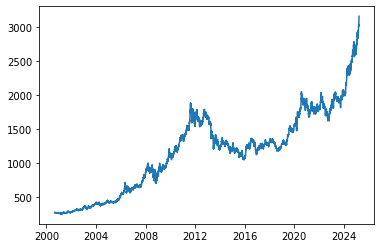

In [8]:
plt.plot(gold_data['Close'])

In [11]:
returns = gold_data['Close'].pct_change()
column_names = gold_data.columns
x = gold_data.values
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [ ]:
pct_c_gold = df

In [ ]:
pct_c_gold.columns = column_names

In [ ]:
pct_c_gold

In [ ]:
returns

In [ ]:
plt.plot(returns)
plt.show()
returns.hist()
plt.show()
returns.mean(), returns.median(), returns.std()



In [ ]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
print(len(npa))
# # Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

In [ ]:

# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
    print(Y)
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

In [ ]:
Y

In [ ]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

In [ ]:
model = keras.Sequential()

# Add a GRU layer with 3 units.
model.add(layers.GRU(3,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))
# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

In [ ]:
print(Y)

In [ ]:
history = model.fit(X[:threshold],
                    Y[:threshold],
                    shuffle = False, # Since this is time series data
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

In [ ]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)

In [ ]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
print(threshold)
true_Y = Y[threshold:]
pred_Y = []
print('Number of Forecasts to do: ',Y.shape[0] - round(Y.shape[0]*0.9))
latest_input = X[threshold-1:threshold]

for i in range(Y.shape[0] - round(Y.shape[0]*0.9) ):
    # Prediction
    p = model.predict(latest_input.reshape(1,X.shape[1],1))[0,0]
    
    # Update predictions
    pred_Y.append(p)
    latest_input = np.append(X[threshold][1:], p)

In [ ]:

plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y, label = 'Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# It's just predicting the mean.

### Multi-Variate Forecasting
## Using our Training and Testing sets, Let's create our inputs.

In [ ]:

# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_gold.shape[0] - samples):
    X.append(pct_c_gold.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_gold.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

In [1]:

#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

NameError: name 'np' is not defined